In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature

import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst
from scipy import ndimage

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
# those three are created from storm cut out kernels (storm netcdf files needed!)

OBS3 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4_ERA5_30km_WA_5-20N_p13.p', 'rb'))

In [4]:
OBS2 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_ERA5_5-20N_p15.p', 'rb'))

In [5]:
OBS3.keys()

dict_keys(['hour', 'month', 'year', 'area', 'lon', 'lat', 'clon', 'clat', 'tmin', 'tmean', 'thetamean', 'thetamax', 'tmidmax', 'tmidmean', 'tsrfcmax', 'tsrfcmean', 'pmax', 'pmean', 'qmax', 'qmean', 'umax_srfc', 'umean_srfc', 'umin_mid', 'umean_mid', 'shearmin', 'shearmean', 'pgt30', 'pgt01isvalid', 't', 'p', 'q', 'u_srfc', 'u_mid', 'shear'])

In [6]:
OBS2.keys()

dict_keys(['hour', 'month', 'year', 'area', 'lon', 'lat', 'clon', 'clat', 'tmin', 'tmean', 'pmax', 'pmean', 'q925', 'q650', 'u925', 'u650', 'v925', 'v650', 'w925', 'w650', 'rh925', 'rh650', 't925', 't650', 'div925', 'div650', 'pv925', 'pv650', 'shear', 'pgt30', 'pgt01isvalid', 't', 'p'])

In [7]:
np.unique(OBS2['month'])

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11])

In [8]:
def create_dic(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])
    umax = np.array(dic['u925'])
    qq = np.array(dic['q925']) 
    qup = np.array(dic['q650'])
    tup = np.array(dic['t650'])
    tlow = np.array(dic['t925'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    
    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    #thetae_up = u_met.theta_e(650, tup-273.15, qup)


    thetae_down_man = u_met.theta_e(925, tlow-273.15, qq)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tlow, 'K')
    q = units.Quantity(qq, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))-273.15
   
    thetae = thetae_down - thetaes_up
    thetaes = thetaes_down - thetaes_up
    
    theta_up = u_met.theta(650, tup-273.15)
    theta_down = u_met.theta(925, tlow-273.15)
    
    theta = theta_down - theta_up

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        't650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'tmean' : ttm,
        'theta' : theta,
        'theta_e' : thetae,
        'lat' : lat,
        'lon' : lon,
    } 
    obs = pd.DataFrame(obs_pcp)
    return obs

In [9]:
def create_dic_model(dic):
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['umin_mid'])
    umax = np.array(dic['umax_srfc'])
    qq = np.array(dic['qmax']) 
    tup = np.array(dic['tmidmax'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    tsrfc = np.array(dic['tsrfcmax'])  
    
    
    #pup = np.array([650]*len(tup))
    
    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup+273.15, 'K')
    #ipdb.set_trace()
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    
    #thetaes_up = []
    
#     for tl in t:
#         try:
#             thetaa = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
#             thetaes_up.append(thetaa)
#             ipdb.set_trace()
#         except:
#             thetaes_up.append(np.nan)

#     thetaes_up = np.array(thetaes_up)

#    ipdb.set_trace()
    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tsrfc+273.15, 'K')
    q = units.Quantity(qq/1000, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    #ipdb.set_trace()
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))
    

    thetae = thetae_down -thetaes_up 
    
    
#     try:
#         thetamax = np.array(dic['thetamax'])
#         thetamean = np.array(dic['thetamean'])   
#     except:
#         pass

    obs_pcp = {
        'prcp' : pp,
        'u650' : umin,
        'u925' : umax,
        'q925' : qq,
        'shear' : sh*-1,
        't925' : tsrfc,
        'month' : month,
        'area' : (area),#*(4.4**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
    } 
    
    try:
        obs_pcp['thetamax']=thetae #thetamax 
        obs_pcp['thetamean']=thetae #thetamean
    except:
        pass
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [10]:
obs_gpm = create_dic(OBS2)
obs_40 = create_dic_model(OBS3)

In [11]:
obs_40['thetamax']

0        9.162470
1        2.821470
2        9.609111
3        6.692487
4        7.467367
           ...   
52538    0.525042
52539    3.654168
52540    5.005283
52541    5.697308
52542    5.317612
Name: thetamax, Length: 52543, dtype: float64

In [12]:
np.max(obs_gpm.lat)

17.74562661158754

In [13]:
obs_gpm.keys()

Index(['prcp', 'u650', 'u925', 'q925', 'q650', 't925', 't650', 'shear',
       'month', 'area', 'tmin', 'tmean', 'theta', 'theta_e', 'lat', 'lon'],
      dtype='object')

In [14]:
obs_gpm.theta_e

0         9.816548
1         5.965535
2         2.154203
3         3.818018
4         8.497525
           ...    
51956    10.451774
51957    11.013062
51958     6.632639
51959    -2.767029
51960     6.021926
Name: theta_e, Length: 51961, dtype: float64

In [15]:
tag = 'Sahel'
domainSA = [-10,12,4.8,8.5]
domainSS = [-12,12,8.5,19]
domainWA = [-10,12,4.8,17.5]

region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(10.5,17.5,17) , np.linspace(0,27,17), np.linspace(-1,15,17)],  #np.linspace(10,17.5,17) , np.linspace(0,25,17)
          'WA' : [domainWA, 'fullWA', np.linspace(10,17.5,17), np.linspace(0,25,17), np.linspace(-7.9,7.9,17)],
          'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,17), np.linspace(0,25,17), np.linspace(-7.9,7.9,17)],
         }

domain = region[tag][0]
tname = region[tag][1]
qbins = region[tag][2]
shearbins = region[tag][3]
thetabins = region[tag][4]
qshearbins = qbins*shearbins

obs_gpm = obs_gpm[(obs_gpm.lon>=domain[0])&(obs_gpm.lon<=domain[1])&(obs_gpm.lat>=domain[2])&(obs_gpm.lat<=domain[3])& (obs_gpm.month>=2) & (obs_gpm.month<=11)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
obs_40 = obs_40[(obs_40.lon>=domain[0])&(obs_40.lon<=domain[1])&(obs_40.lat>=domain[2])&(obs_40.lat<=domain[3])& (obs_40.month>=2) & (obs_40.month<=11)]


In [16]:
print('OBS_40', obs_40.lat.min(), obs_40.lat.max(), obs_40.lon.min(), obs_40.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

OBS_40 8.502001523971558 18.97125244140625 -11.76275634765625 11.76776123046875
OBS_gpm 8.50007155018848 17.74562661158754 -11.998787551565622 11.996942654145766


Text(0.5, 1.0, '-0.53')

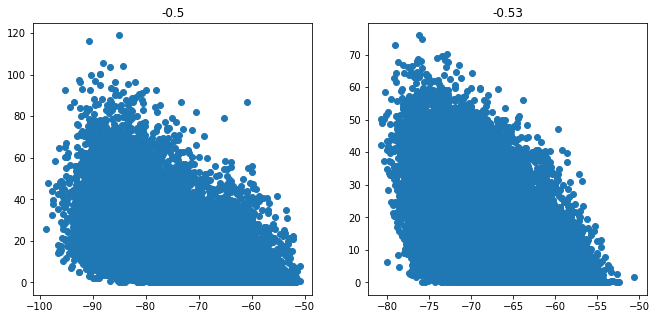

In [17]:

cp4s = [obs_gpm.tmin, obs_gpm.prcp] # gpm
cp25s = [obs_40.tmin, obs_40.prcp] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(121)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(122)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)




Text(0.5, 1.0, '-0.41')

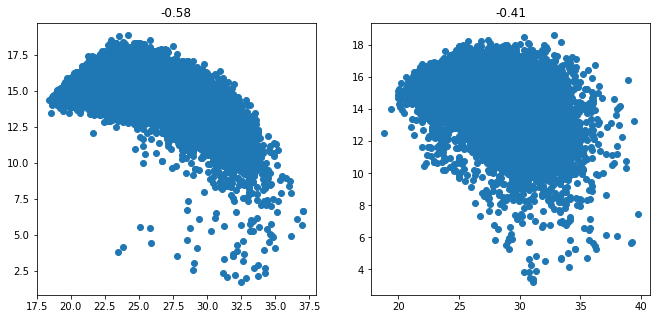

In [18]:

cp4s = [obs_gpm.t925, obs_gpm.q925] # gpm
cp25s = [obs_40.t925, obs_40.q925] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(121)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(122)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)



Text(0.5, 1.0, '0.15')

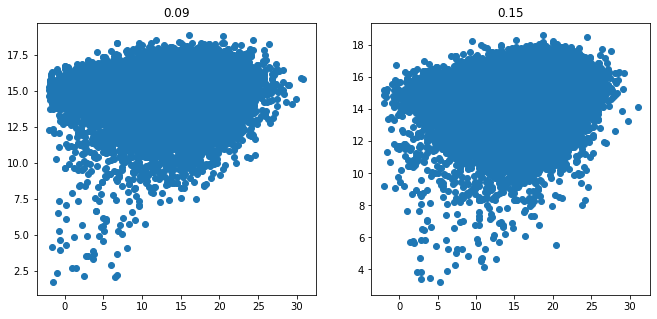

In [19]:

cp4s = [(obs_gpm.shear)[obs_gpm.shear>-2], obs_gpm.q925[obs_gpm.shear>-2]] # gpm
cp25s = [(obs_40.shear)[obs_40.shear>-2], obs_40.q925[obs_40.shear>-2]] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(121)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(122)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)



(8.0, 19.0)

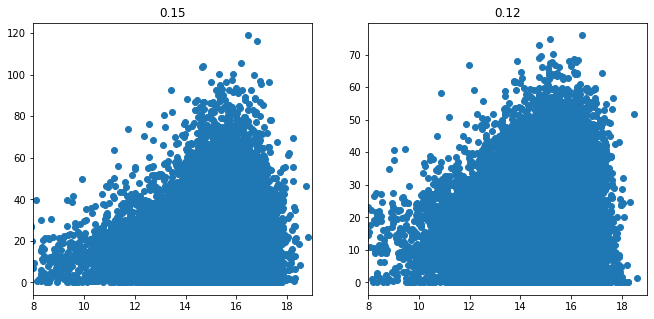

In [20]:
cp4s = [obs_gpm.q925, obs_gpm.prcp] # gpm
cp25s = [obs_40.q925, obs_40.prcp] #cp4


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(121)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))
ax.set_xlim(8,19)

ax = f.add_subplot(122)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)
ax.set_xlim(8,19)



Text(0.5, 1.0, '0.01')

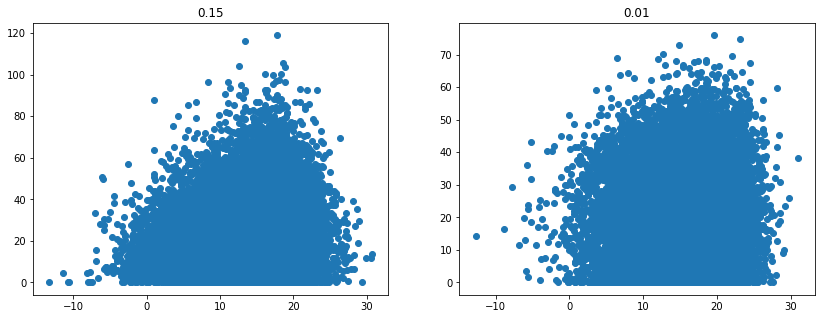

In [21]:

cp4s = [obs_gpm.shear, obs_gpm.prcp] # gpm
cp25s = [obs_40.shear, obs_40.prcp] #cp4


f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(122)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,50)


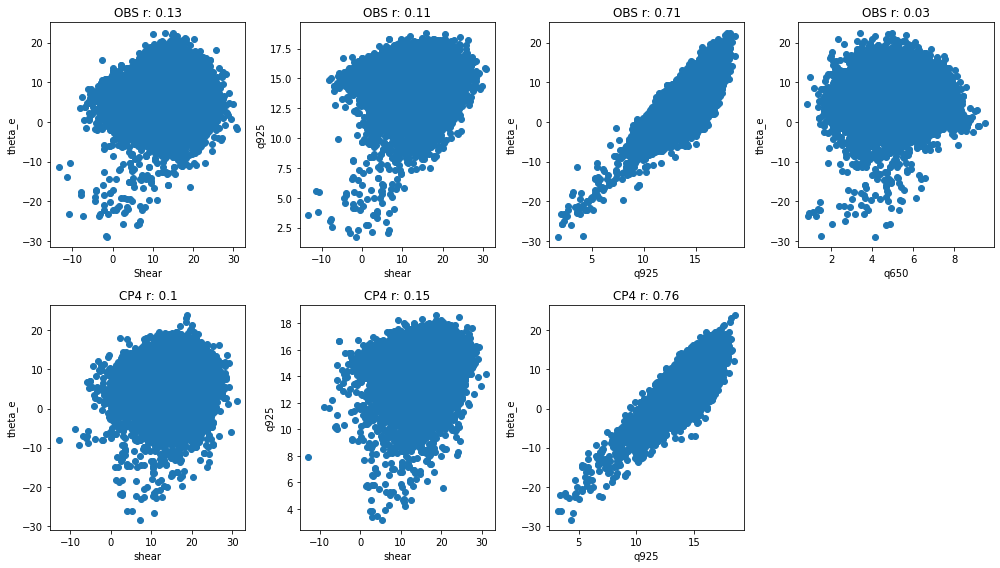

In [22]:
obss = [obs_40.shear, obs_40.thetamax, obs_40.q925, obs_40.tmin, obs_40.prcp] # cp4
cp4s = [obs_gpm.shear, obs_gpm.theta_e, obs_gpm.q925, obs_gpm.tmin, obs_gpm.prcp, obs_gpm.q650,  obs_gpm.t650]  # gpm

f = plt.figure(figsize=(14,8))
ax = f.add_subplot(241)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title('OBS r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('Shear')
plt.ylabel('theta_e')

ax = f.add_subplot(242)
r = stats.pearsonr(cp4s[0],cp4s[2])
plt.scatter(cp4s[0],cp4s[2])
plt.title('OBS r: '+ str(np.round(r[0], decimals=2)))
plt.xlabel('shear')
plt.ylabel('q925')

ax = f.add_subplot(243)
r = stats.pearsonr(cp4s[2],cp4s[1])
plt.scatter(cp4s[2],cp4s[1])
plt.title('OBS r: '+ str(np.round(r[0], decimals=2)))
plt.xlabel('q925')
plt.ylabel('theta_e')

ax = f.add_subplot(244)
r = stats.pearsonr(cp4s[5],cp4s[1])
plt.scatter(cp4s[5],cp4s[1])
plt.title('OBS r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('q650')
plt.ylabel('theta_e')


ax = f.add_subplot(245)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('shear')
plt.ylabel('theta_e')

ax = f.add_subplot(246)
plt.scatter(obss[0],obss[2])
r = stats.pearsonr(obss[0],obss[2])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('shear')
plt.ylabel('q925')

ax = f.add_subplot(247)
plt.scatter(obss[2],obss[1])
r = stats.pearsonr(obss[2],obss[1])
plt.title('CP4 r: '+str(np.round(r[0], decimals=2)))
plt.xlabel('q925')
plt.ylabel('theta_e')

# ax = f.add_subplot(248)
# r = stats.pearsonr(cp4s[6],cp4s[1])
# plt.scatter(cp4s[6],cp4s[1])
# plt.title('OBS r: '+str(np.round(r[0], decimals=2)))
# plt.xlabel('t650')
# plt.ylabel('theta_e')

plt.tight_layout()
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)

#plt.savefig(cnst.network_data + 'figs/CLOVER/scatter_SoudanoSahel_OBS_CP4.png')

Text(0.5, 1.0, '0.76')

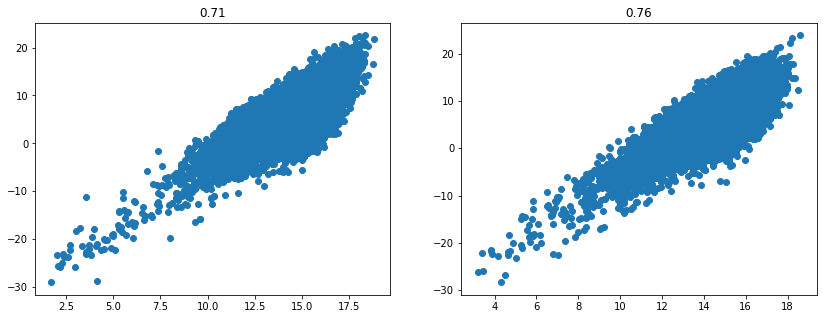

In [23]:
obss = [obs_40.q925[obs_40.thetamax>=-40], obs_40.thetamax[obs_40.thetamax>=-40]] # cp4
cp4s = [obs_gpm.q925, obs_gpm.theta_e] # gpm



f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))



ax = f.add_subplot(122)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
#ax.set_ylim(0,150)
#ax.set_ylim(13,19)

In [92]:
oposi = (obs_gpm.q925>=10) & (obs_gpm.shear>0) &  (obs_gpm.prcp>=5) & (obs_gpm.theta_e>=-40)# & ((obs_gpm.month>=9) | (obs_gpm.month<=5))   prcp >=5
cposi = (obs_40.q925>=10) & (obs_40.shear>0) &  (obs_40.prcp>=5) & (np.isfinite(obs_40.q925)) & (np.isfinite(obs_40.shear)  & (obs_40.area>=258))

In [93]:
obs = obs_gpm[oposi]
cp4 = obs_40[cposi]
cp4.area = cp4.area.values*(4.4**2)

/home/ck/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [94]:
cp4.area.min()

4994.880000000001

In [95]:
obs.keys()

Index(['prcp', 'u650', 'u925', 'q925', 'q650', 't925', 't650', 'shear',
       'month', 'area', 'tmin', 'tmean', 'theta', 'theta_e', 'lat', 'lon'],
      dtype='object')

In [96]:
len(obs)

24929

In [97]:
len(cp4)

25949

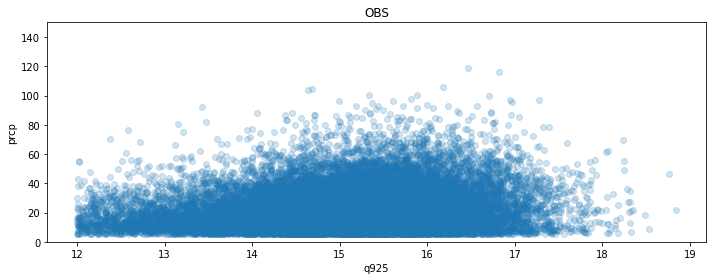

In [98]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = obs.q925>12
plt.scatter(obs.where(isqq).q925, obs.where(isqq).prcp, alpha=0.2)
plt.xlabel('q925')
plt.title('OBS')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

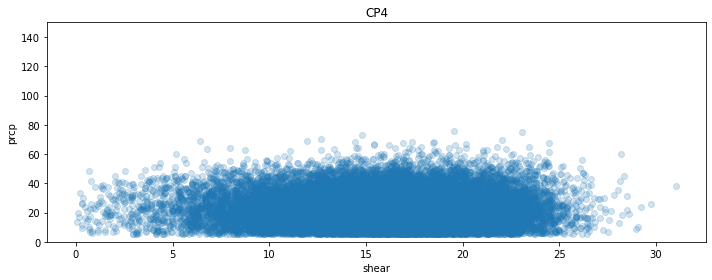

In [99]:
f = plt.figure(figsize=(10,4))

ax = f.add_subplot(111)
isqq = cp4.q925>12
plt.scatter(cp4.where(isqq).shear, cp4.where(isqq).prcp, alpha=0.2)
plt.xlabel('shear')
plt.title('CP4')
plt.ylabel('prcp')
ax.set_ylim(0,150)
plt.tight_layout()

In [100]:
print(obs['q925'].median())
print(obs['shear'].median())
print(obs['prcp'].median())
print(obs['tmin'].median())
print(obs['theta_e'].median())

15.125341713428497
13.697099685668945
18.647946134090816
-78.84487583274009
6.911872417548409


In [101]:
print(obs['q925'].mean())
print(obs['shear'].mean())
print(obs['prcp'].mean())
print(obs['tmin'].mean())
print(obs['theta_e'].mean())

14.971857466648833
13.405378508474083
22.14205459445469
-78.02547344062457
6.890855726930745


In [102]:
def create_2dhist(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))
    outarea_ds = np.zeros((len(ybins),len(xbins)))

    for isq, qql in enumerate(ybins[0:-1]):

        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.q925>=qql) & (ds.q925 < ybins[isq+1])
          
            try:
                ds_mmean = np.nansum(ds.tmin[poss_ds])#np.percentile(ds.tmin[poss_ds], 50)
                ds_val = np.sum(np.isfinite(ds.tmin[poss_ds]))
                if ds_val < 5:
                    ds_mean = np.nan
                else:
                    ds_mean = ds_mmean/ds_val          
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mmean = np.nansum(ds.prcp[poss_ds]) ##np.percentile(ds.prcp[poss_ds], 50)
                prcp_val = np.sum(np.isfinite(ds.prcp[poss_ds]))
                if prcp_val < 5:
                    prcp_mean = np.nan
                else:
                    prcp_mean = prcp_mmean/prcp_val  
            except:
                prcp_mean = np.nan
                
            try:
                ds_ammean = np.nansum(ds.area[poss_ds])
                area_val = np.sum(np.isfinite(ds.area[poss_ds]))
                if area_val < 5:
                    ds_amean = np.nan
                else:
                    ds_amean = ds_ammean/area_val  
            except IndexError:
                ds_amean = np.nan
            
            outarea_ds[issh,isq] = ds_amean
            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp, outval, outarea_ds

In [103]:
def create_2dhist_theta(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_tt = np.zeros((len(ybins),len(xbins)))
    outperc_pp = np.zeros((len(ybins),len(xbins)))
    outval = np.zeros((len(ybins),len(xbins)))

    corrlist = []
    stdlist = []
    
    if 'theta_e' in ds.keys():
        tvar = 'theta_e'
    else:
        tvar = 'thetamax'
    
    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds[tvar]>=qql) & (ds[tvar] < ybins[isq+1])
          
            try:
                ds_mmean = np.nansum(ds.tmin[poss_ds])#np.percentile(ds.tmin[poss_ds], 50)
                ds_val = np.sum(np.isfinite(ds.tmin[poss_ds]))
                if ds_val < 5:  #2
                    ds_mean = np.nan
                else:
                    ds_mean = ds_mmean/ds_val          
            except IndexError:
                ds_mean = np.nan
                
            try:
                prcp_mmean = np.nansum(ds.prcp[poss_ds]) ##np.percentile(ds.prcp[poss_ds], 50)
                prcp_val = np.sum(np.isfinite(ds.prcp[poss_ds]))
                if prcp_val < 5:
                    prcp_mean = np.nan
                else:
                    prcp_mean = prcp_mmean/prcp_val  
            except:
                prcp_mean = np.nan

            outperc_tt[issh,isq] = ds_mean
            outperc_pp[issh,isq] = prcp_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_tt, outperc_pp,  outval

In [104]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    
    for i, dat in enumerate(data):
        if (i==2) | (i==3):
            cmap = 'Blues'
        else:
            cmap = 'Reds_r'
            
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(10, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],11)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/CLOVER/OBS_CP4_2dHist_SoudanoSahel_15km_thetae_shear.png')

In [105]:
obsT, obsP,  obsVAL, obsAREA = create_2dhist(obs, shearbins, qbins)

In [106]:
tobsT, tobsP,  tobsVAL = create_2dhist_theta(obs, shearbins, thetabins)

In [107]:
T4, P4,  VAL4, area4 = create_2dhist(cp4, shearbins, qbins)

In [108]:
tT4, tP4,  tVAL4 = create_2dhist_theta(cp4, shearbins, thetabins)

In [109]:
thetabins

array([-1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,
       12., 13., 14., 15.])

In [110]:
tvmin = -83
tvmax = -64

pvmin = 17
pvmax = 27

avmin = 5000
avmax = 90500

thetatmin_dic_obs = {
    'data' : tobsT,
    'ybins' : thetabins,
    'xbins' : shearbins,
    'title' : 'OBS: Average min. CTT',
    'valid' : tobsVAL,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin, 
    'vmax' : tvmax, 
    'ylabel' : r'$\Delta \theta _{e-es}$ (K)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


tmin_dic_obs = {
    'data' : obsT,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'OBS: Average min. CTT',
    'valid' : obsVAL,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin,
    'vmax' : tvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}



obsP[obsP==0]=np.nan
prcp_dic_obs = {
    'data' : obsP,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'OBS: Average max. precipitation',
    'valid' : obsVAL,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : pvmin, 
    'vmax' : pvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


tobsP[tobsP==0]=np.nan
thetaprcp_dic_obs = {
    'data' : tobsP,
    'ybins' : thetabins,
    'xbins' : shearbins,
    'title' : 'OBS: Average max. precipitation',
    'valid' : tobsVAL,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : pvmin, 
    'vmax' : pvmax, 
    'ylabel' : r'$\Delta \theta _{e-es}$ (K)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


area_dic = {
    'data' : obsAREA,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'OBS: MCS area',
    'valid' : obsVAL,
    'cbarlabel' : r'km$^{2}$',
    'vmin' : avmin, 
    'vmax' : avmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-2}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

In [111]:

############T: q shear
data = T4
tmin_dic_cp4 = {
    
    'data' : data,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'CP4: Average min. CTT',
    'valid' : VAL4,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin, 
    'vmax' : tvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

############Area: q shear
data = area4
area_dic_cp4 = {
    
    'data' : data,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'CP4: MCS area',
    'valid' : VAL4,
    'cbarlabel' : r'km$^{2}$',
    'vmin' : avmin , 
    'vmax' : avmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

#######T: theta shear
data =tT4
thetatmin_dic_cp4 = {
    
    'data' : data,
    'ybins' : thetabins,
    'xbins' : shearbins,
    'title' : 'CP4: Average min. CTT',
    'valid' : tVAL4,
    'cbarlabel' : '${\circ}$C',
    'vmin' : tvmin,
    'vmax' : tvmax,
    'ylabel' : r'$\Delta \theta _{e-es}$ (K)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


############Precip: q shear
P4[P4==0]=np.nan
data = P4
prcp_dic_cp4 = {
    'data' : data,
    'ybins' : qbins,
    'xbins' : shearbins,
    'title' : 'CP4: Average max. precipitation',
    'valid' : VAL4,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : pvmin, 
    'vmax' : pvmax, 
    'ylabel' : 'Low-level humidity (g kg$^{-1}$)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}


############Precip: theta shear
tP4[tP4==0]=np.nan
data = tP4
thetaprcp_dic_cp4 = {
    'data' : data,
    'ybins' : thetabins,
    'xbins' : shearbins,
    'title' : 'CP4: Average max. precipitation',
    'valid' : tVAL4,
    'cbarlabel' : 'mm h$^{-1}$',
    'vmin' : pvmin,
    'vmax' : pvmax, 
    'ylabel' : r'$\Delta \theta _{e-es}$ (K)',
    'xlabel' : 'Wind shear (m s$^{-1}$)'
}

In [112]:
shearscat = np.repeat(shearbins,obsP.shape[0],axis=0).reshape(obsP.shape)

In [113]:
qscat = np.repeat(qbins[np.newaxis,:],obsP.shape[0],axis=0).reshape(obsP.shape)

In [114]:
thetascat = np.repeat(thetabins[np.newaxis,:],obsP.shape[0],axis=0).reshape(obsP.shape)

In [115]:
def binning_2dhist(prcp, tmin, bins):
    ps = []
    qps = []
    sbox = []
    tbox = []
    mean = []
    percup = []
    percdown = []
    tmean = []
    tpercup = []
    tpercdown = []
    for sh in np.unique(bins):

            vals = prcp[sh==bins]
            tvals = tmin[sh==bins]
            ps.append(np.nanmax(vals)-np.nanmin(vals))
            try:
                qps.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
            except:
                qps.append(np.nan)
            sbox.append(vals)
            
            vv = np.nanmean(vals)
            nans = np.sum(np.isnan(vals))
#             if nans > 1:
#                 vv = np.nan
            
            mean.append(vv)
            try:
                percup.append(np.percentile(vals[np.isfinite(vals)],75))
                percdown.append(np.percentile(vals[np.isfinite(vals)],25))
            except:
    #             qp90.append(np.nan)
    #             qp10.append(np.nan)
                pass
            tvals[tvals==0] = np.nan
            tbox.append(tvals)
            
            tt = np.nanmean(tvals)
            nans = np.sum(np.isnan(tvals))
#             if nans > 2:
#                 tt = np.nan
            tmean.append(tt)
            try:
                tpercup.append(np.percentile(tvals[np.isfinite(tvals)],75))
                tpercdown.append(np.percentile(tvals[np.isfinite(tvals)],25))
            except:
    #             qp90.append(np.nan)
    #             qp10.append(np.nan)
                pass
            
            
    print(np.median(np.array(qps)[np.isfinite(np.array(qps))]))
    return ps, qps, sbox, tbox, mean, percup, percdown, tmean, tpercup, tpercdown

In [116]:
deltaPS, deltaQPS, sboxplot, tminbox,pmean,p90,p10, tmean, t90, t10 = binning_2dhist(obsP, obsT, shearscat)
deltaPS4, deltaQPS4, sboxplot4, tminbox4,pmean4,p904,p104, tmean4, t904, t104 = binning_2dhist(P4, T4, shearscat)

4.479277051430621
4.812641206724521


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: All-NaN slice encountered
  app.launch_new_instance()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


In [117]:
deltaPQ, deltaQPQ, boxplotq, tminboxq,pqmean,pq90,pq10, tqmean, tq90, tq10 = binning_2dhist(obsP, obsT, qscat)
deltaPQ4, deltaQPQ4, boxplotq4, tminboxq4,pqmean4,pq904,pq104,tqmean4, tq904, tq104 = binning_2dhist(P4, T4, qscat)

3.745488328737025
1.5897141002863524


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: All-NaN slice encountered
  app.launch_new_instance()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


In [118]:
thetaPQ, thetaQPQ, boxtheta, tmintheta,meantheta,theta90,theta10, tmeantheta, ttheta90, ttheta10 = binning_2dhist(tobsP, tobsT, thetascat)
thetaPQ4, thetaQPQ4, boxtheta4, tmintheta4,meantheta4,theta904,theta104, tmeantheta4, ttheta904, ttheta104 = binning_2dhist(tP4, tT4, thetascat)

5.090385378110792
1.7870232757257778


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: All-NaN slice encountered
  app.launch_new_instance()
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


In [119]:
scollbins = np.round(np.unique(shearscat),2)
scollbins = np.round(scollbins[0:-1]+((scollbins[1::]-scollbins[0:-1])/2),0)
qcollbins = np.round(np.unique(qscat),2)
qcollbins = np.round(qcollbins[0:-1]+((qcollbins[1::]-qcollbins[0:-1])/2),2)
thcollbins = np.round(np.unique(thetascat),2)
thcollbins = np.round(thcollbins[0:-1]+((thcollbins[1::]-thcollbins[0:-1])/2),2)

17
17


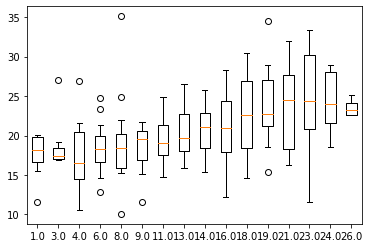

In [120]:
scoll = []
scollbins = np.round(np.unique(shearscat),2)
scollbins = np.round(scollbins[0:-1]+((scollbins[1::]-scollbins[0:-1])/2),0)
for b in sboxplot:
    scoll.append(b[np.isfinite(b)])
print(len(scoll))
print(len(np.unique(shearscat)))
plt.figure()
ax = plt.boxplot(scoll[0:-1], labels=scollbins, whis=1)
box1= (scoll[0:-1],scollbins)

17
17


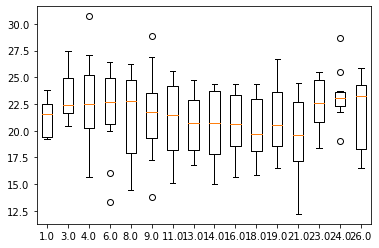

In [121]:
scoll4 = []
scollbins4 = np.round(np.unique(shearscat),2)
scollbins4 = np.round(scollbins4[0:-1]+((scollbins4[1::]-scollbins4[0:-1])/2),0)
for b in sboxplot4:
    scoll4.append(b[np.isfinite(b)])
print(len(scoll4))
print(len(np.unique(shearscat)))
plt.figure()
ax = plt.boxplot(scoll4[0:-1], labels=scollbins4, whis=1)
box1= (scoll4[0:-1],scollbins4)

In [122]:
outs = []
for pcol4 in scoll4[0:-1]:
    outs.append(np.mean(pcol4))

In [123]:
len(outs)

16

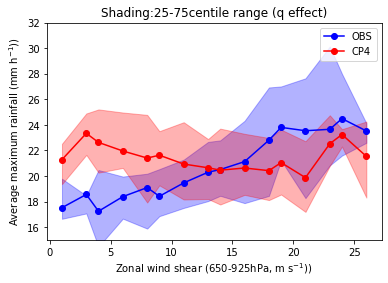

In [124]:
plt.figure()
plt.plot(scollbins,pmean[0:-1], '-bo', label='OBS')
plt.fill_between(scollbins,p10,p90, color='blue', alpha=0.3)
plt.fill_between(scollbins,p104,p904, color='red', alpha=0.3)
plt.plot(scollbins,outs, '-ro', label='CP4') #pmean4[0:-1]
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$))')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$))')
plt.title('Shading:25-75centile range (q effect)')
#plt.ylim(15,47)
plt.ylim(15,32)
plt.legend()

In [125]:
PSslope, PSintercept, PSr_value, PSp_value, PSstd_err = stats.linregress(scollbins, pmean[0:-1])
PQslope, PQintercept, PQr_value, PQp_value, PQstd_err = stats.linregress(qcollbins, pqmean[0:-1])
PTslope, PTintercept, PTr_value, PTp_value, PTstd_err = stats.linregress(thcollbins, meantheta[0:-1])

TSslope, TSintercept, TSr_value, TSp_value, TSstd_err = stats.linregress(scollbins, tmean[0:-1])
TQslope, TQintercept, TQr_value, TQp_value, TQstd_err = stats.linregress(qcollbins, tqmean[0:-1])
TTslope, TTintercept, TTr_value, TTp_value, TTstd_err = stats.linregress(thcollbins, tmeantheta[0:-1])

In [126]:
PSslope4, PSintercept4, PSr_value4, PSp_value4, PSstd_err4 = stats.linregress(scollbins, pmean4[0:-1])
PQslope4, PQintercept4, PQr_value4, PQp_value4, PQstd_err4 = stats.linregress(qcollbins, pqmean4[0:-1])
PTslope4, PTintercept4, PTr_value4, PTp_value4, PTstd_err4 = stats.linregress(thcollbins, meantheta4[0:-1])

TSslope4, TSintercept4, TSr_value4, TSp_value4, TSstd_err4 = stats.linregress(scollbins, tmean4[0:-1])
TQslope4, TQintercept4, TQr_value4, TQp_value4, TQstd_err4 = stats.linregress(qcollbins, tqmean4[0:-1])
TTslope4, TTintercept4, TTr_value4, TTp_value4, TTstd_err4 = stats.linregress(thcollbins, tmeantheta4[0:-1])

In [127]:
PSintercept

16.662592577302327

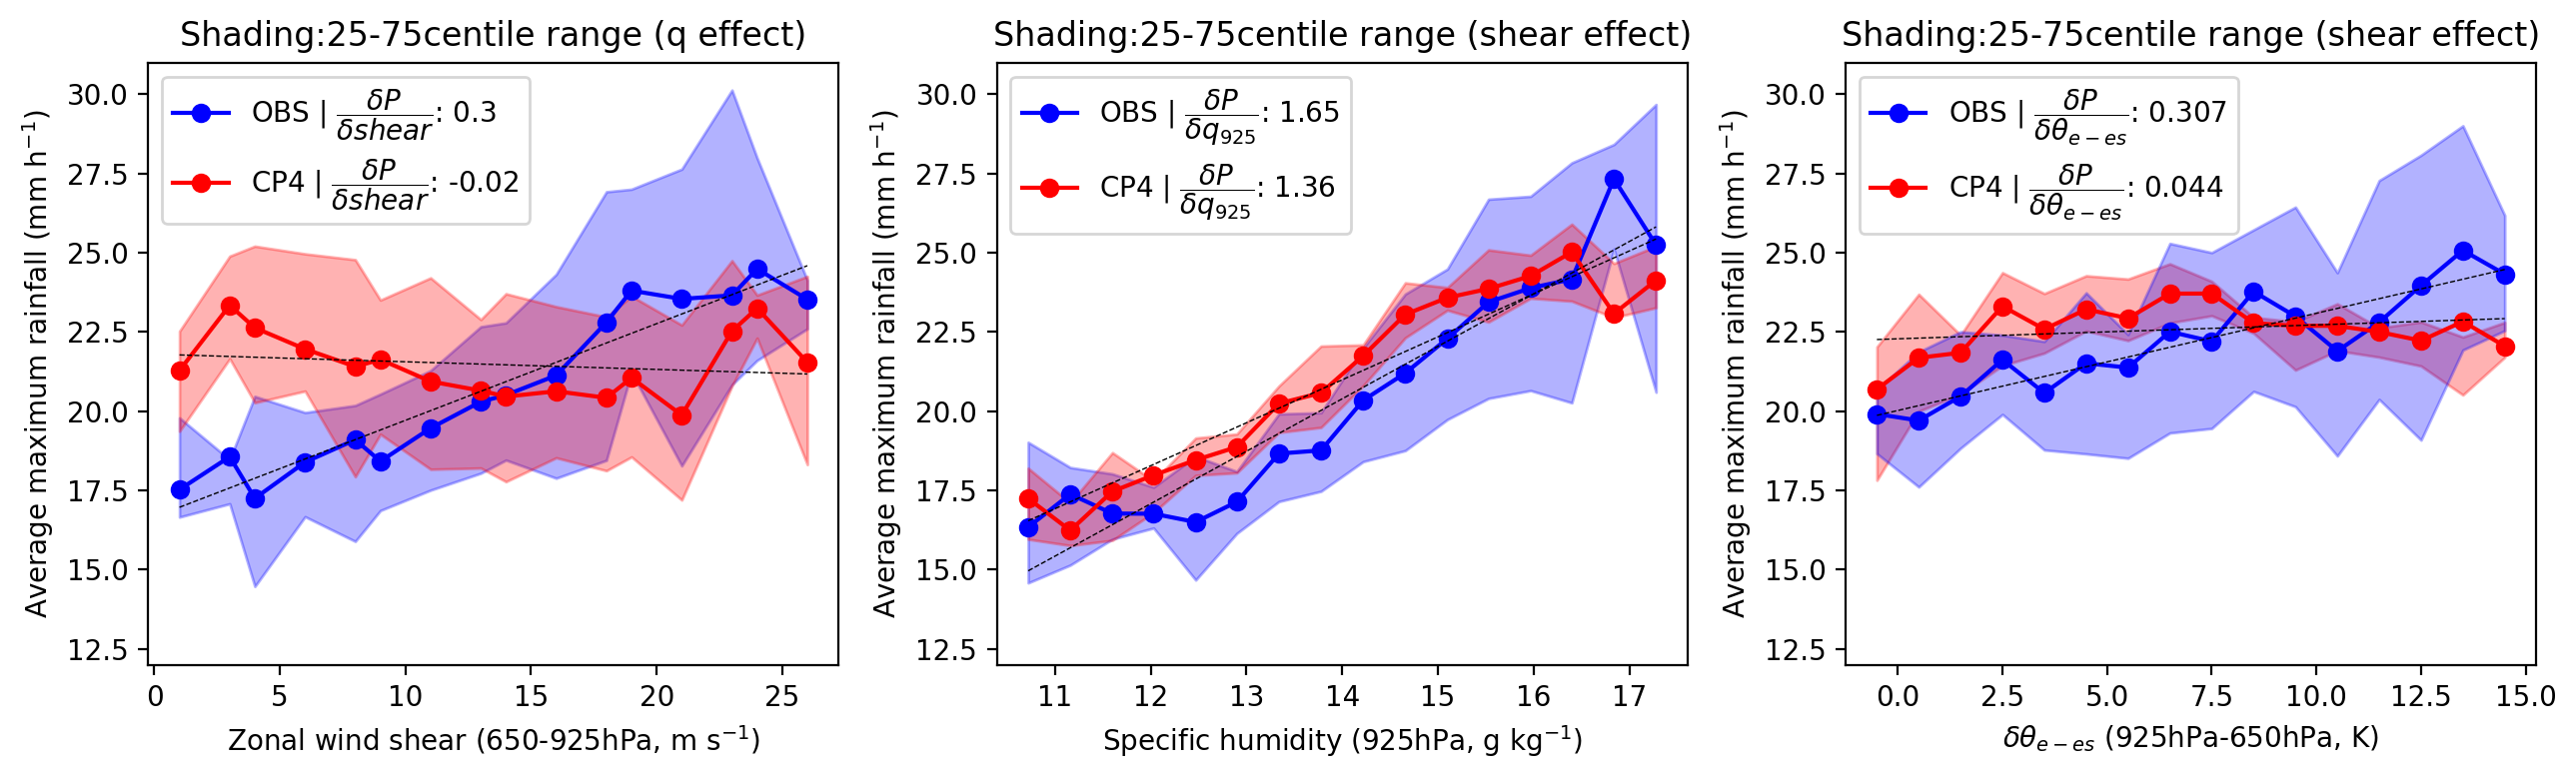

In [128]:
f = plt.figure(figsize=(13,4), dpi=200)
ax = f.add_subplot(131)

plt.plot(scollbins,pmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(PSslope,2)))
plt.fill_between(scollbins,p10,p90, color='blue', alpha=0.3)
plt.fill_between(scollbins,p104,p904, color='red', alpha=0.3)
plt.plot(scollbins,pmean4[0:-1], '-ro', label='CP4 | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(PSslope4,2)))
plt.plot(scollbins,PSslope*scollbins+PSintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(scollbins,PSslope4*scollbins+PSintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (q effect)')
plt.ylim(12,31)
#plt.ylim(15,33)
plt.legend(loc='upper left')

ax = f.add_subplot(132)
plt.plot(qcollbins,pqmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(PQslope,2)))
plt.fill_between(qcollbins,pq10,pq90, color='blue', alpha=0.3)
plt.fill_between(qcollbins,pq104,pq904, color='red', alpha=0.3)
plt.plot(qcollbins,pqmean4[0:-1], '-ro', label=r'CP4 | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(PQslope4,2)))
plt.plot(qcollbins,PQslope*qcollbins+PQintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(qcollbins,PQslope4*qcollbins+PQintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')

plt.ylim(12,31)
#plt.ylim(15,33)
plt.legend(loc='upper left')

ax = f.add_subplot(133)
plt.plot(thcollbins,meantheta[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(PTslope,3)))
plt.fill_between(thcollbins,theta104,theta904, color='red', alpha=0.3)
plt.fill_between(thcollbins,theta10,theta90, color='blue', alpha=0.3)
plt.plot(thcollbins,meantheta4[0:-1], '-ro', label=r'CP4 | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(PTslope4,3)))
plt.plot(thcollbins,PTslope*thcollbins+PTintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(thcollbins,PTslope4*thcollbins+PTintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel(r'$\delta \theta _{e-es}$ (925hPa-650hPa, K)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
plt.ylim(12,31)
#plt.ylim(1,33)
plt.legend(loc='upper left')

plt.tight_layout()
#f.savefig(cnst.network_data +'figs/CLOVER/OBS_CP4_lineplot_'+tag+'_15km_rain.png')

In [129]:
len(thcollbins)

16

In [130]:
len(theta904)

16

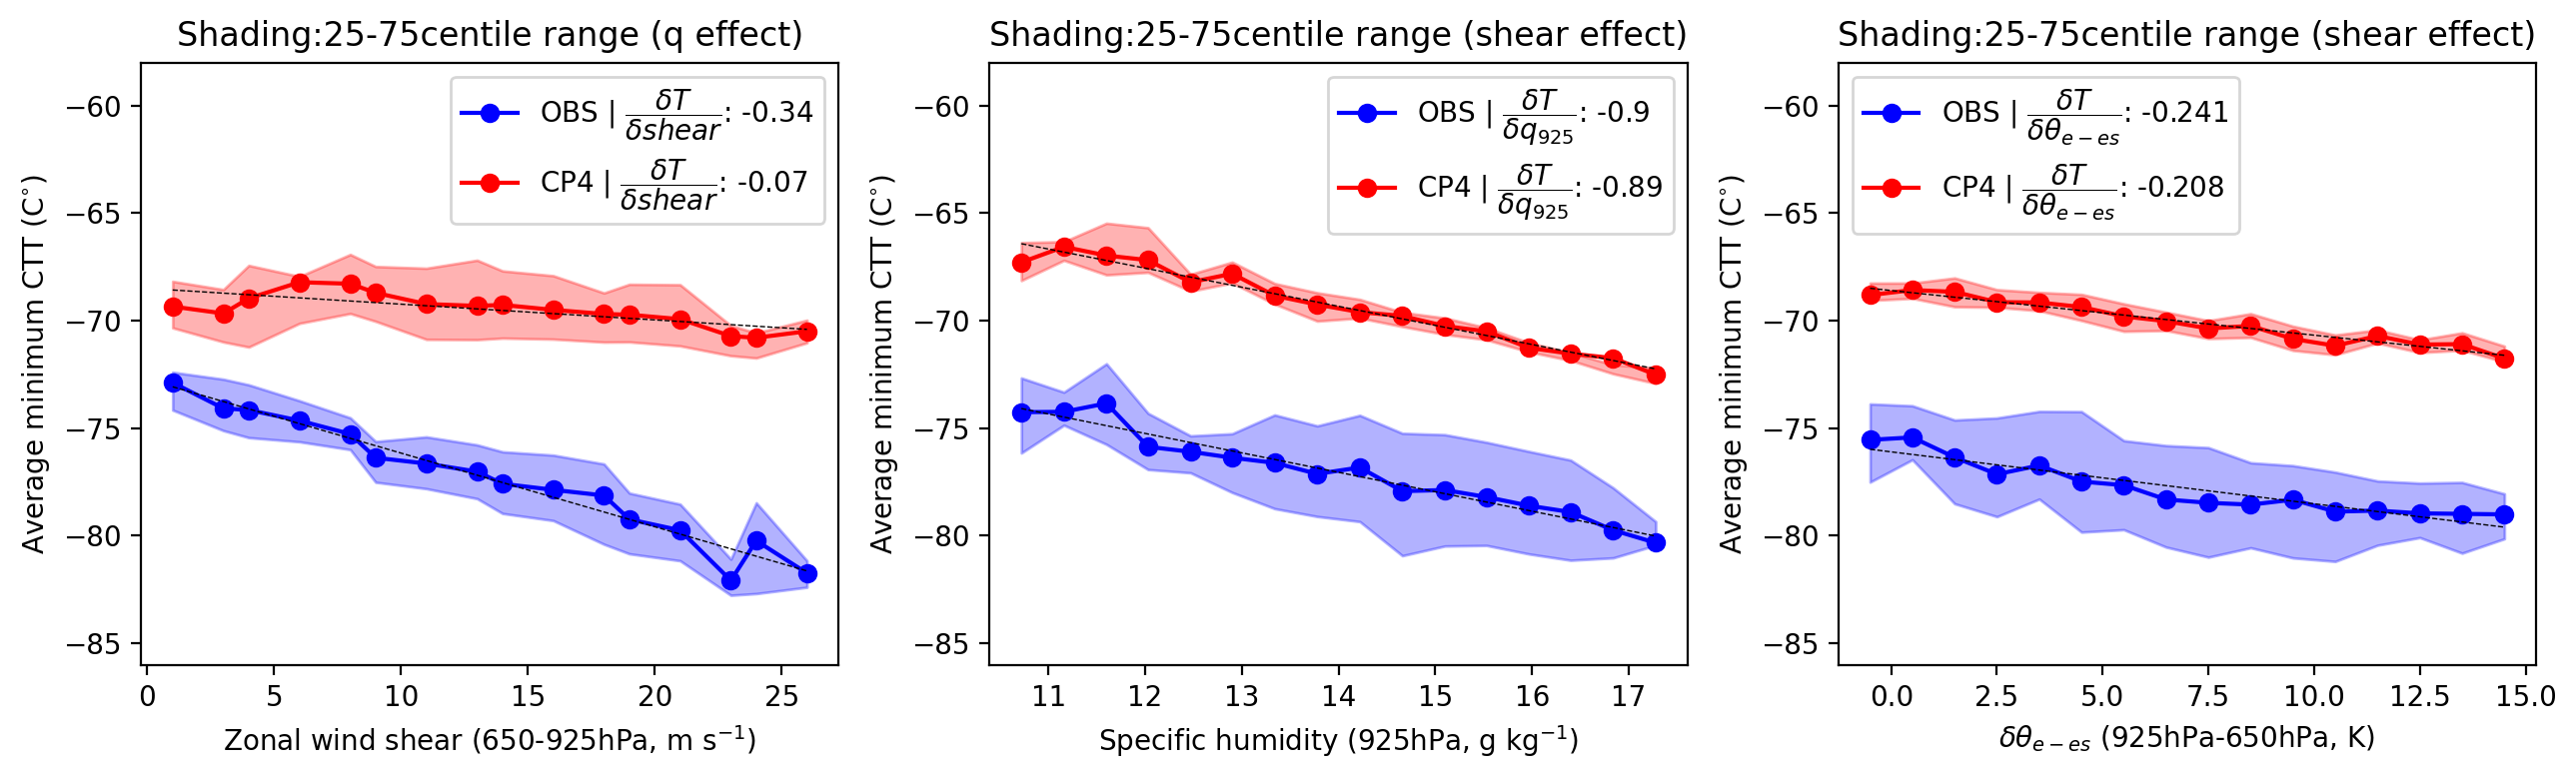

In [131]:
f = plt.figure(figsize=(13,4), dpi=200)
ax = f.add_subplot(131)

plt.plot(scollbins,tmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta T}{\delta shear}$: ' + str(np.round(TSslope,2)))
plt.fill_between(scollbins,t10,t90, color='blue', alpha=0.3)
plt.fill_between(scollbins,t104,t904, color='red', alpha=0.3)
plt.plot(scollbins,tmean4[0:-1], '-ro', label='CP4 | $\dfrac{\delta T}{\delta shear}$: ' + str(np.round(TSslope4,2)))
plt.plot(scollbins,TSslope*scollbins+TSintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(scollbins,TSslope4*scollbins+TSintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel(r'Average minimum CTT (C$^{\circ}$)')
plt.title('Shading:25-75centile range (q effect)')
plt.ylim(-86,-58)
plt.legend(loc='upper right')

ax = f.add_subplot(132)
plt.plot(qcollbins,tqmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta T}{\delta q_{925}}$: ' + str(np.round(TQslope,2)))
plt.fill_between(qcollbins,tq10,tq90, color='blue', alpha=0.3)
plt.fill_between(qcollbins,tq104,tq904, color='red', alpha=0.3)
plt.plot(qcollbins,tqmean4[0:-1], '-ro', label=r'CP4 | $\dfrac{\delta T}{\delta q_{925}}$: ' + str(np.round(TQslope4,2)))
plt.plot(qcollbins,TQslope*qcollbins+TQintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(qcollbins,TQslope4*qcollbins+TQintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')
plt.ylabel(r'Average minimum CTT (C$^{\circ}$)')
plt.title('Shading:25-75centile range (shear effect)')
plt.ylim(-86,-58)
plt.legend(loc='upper right')

ax = f.add_subplot(133)
plt.plot(thcollbins,tmeantheta[0:-1], '-bo', label=r'OBS | $\dfrac{\delta T}{\delta \theta _{e-es}}$: ' + str(np.round(TTslope,3)))
plt.fill_between(thcollbins,ttheta10,ttheta90, color='blue', alpha=0.3)
plt.fill_between(thcollbins,ttheta104,ttheta904, color='red', alpha=0.3)
plt.plot(thcollbins,tmeantheta4[0:-1], '-ro', label=r'CP4 | $\dfrac{\delta T}{\delta \theta _{e-es}}$: ' + str(np.round(TTslope4,3)))
plt.plot(thcollbins,TTslope*thcollbins+TTintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(thcollbins,TTslope4*thcollbins+TTintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel(r'$\delta \theta _{e-es}$ (925hPa-650hPa, K)')
plt.ylabel(r'Average minimum CTT (C$^{\circ}$)')
plt.title('Shading:25-75centile range (shear effect)')
plt.ylim(-86,-58)
plt.legend(loc='upper left')

plt.tight_layout()
#f.savefig(cnst.network_data +'figs/CLOVER/OBS_CP4_lineplot_'+tag+'_15km_tmin.png')

In [132]:
# sensitivity = {}
# sensitivity['shear_slope'] = slope
# sensitivity['qslope'] = qslope 
# pkl.dump(sensitivity, open(cnst.CLOVER_SAVES + 'q_shear_sensitivity_slopes', 'wb'))

In [133]:
def hist2d_six_area(data, valid=False):
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
    f = plt.figure(figsize=(15,8))
    for i, dat in enumerate(data):
        
        
        
        print(i)
        ax = f.add_subplot(2,3,i+1)
        if i in [0,3]:
            cmap = 'Reds_r'
            
        if i in [1,4]:
            cmap = 'Blues'
        if i in[2,5]:
            cmap = 'Purples'
            
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(12, base_cmap=cmap)
#         if valid:
            
#             dat['data'][dat['valid']<5] = np.nan
        Zm = dat['data'].copy()
        npos = np.isnan(Zm)
#         if i in [0,3]:
#             Zm[np.isnan(Zm)] = np.nanmean(Zm)
#         else:
#             Zm[np.isnan(Zm)] = np.nanmax(Zm)
#         Zm = ndimage.gaussian_filter(Zm, 0.6, mode='nearest')
        #Zm = ma.masked_where(np.isnan(Zm),Zm)
        Zm = ma.masked_where(npos,Zm)
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],13)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 
    #plt.savefig(cnst.network_data + 'figs/CLOVER/OBS_CP4_2dHist_'+tag+'_15km.png')

In [134]:
data_list = [tmin_dic_obs, prcp_dic_obs, area_dic, tmin_dic_cp4,  prcp_dic_cp4, area_dic_cp4]

0
1
2
3
4
5


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


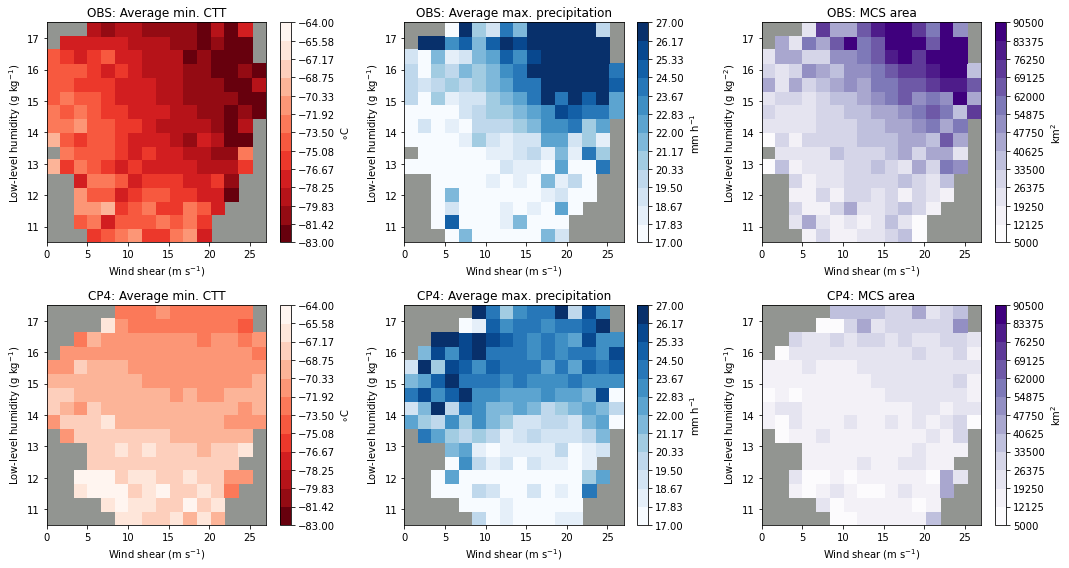

In [135]:
hist2d_six_area(data_list, valid=True)

In [136]:
data_list = [thetatmin_dic_obs, thetatmin_dic_cp4, thetaprcp_dic_obs, thetaprcp_dic_cp4]

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


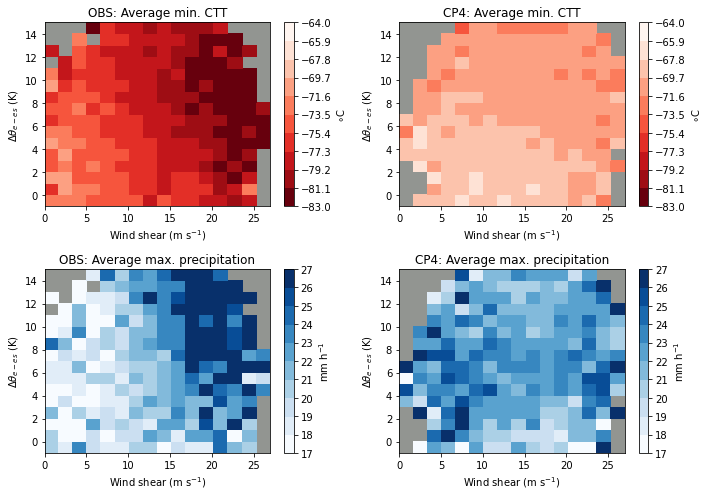

In [137]:
hist2d_quatro(data_list, valid=True)

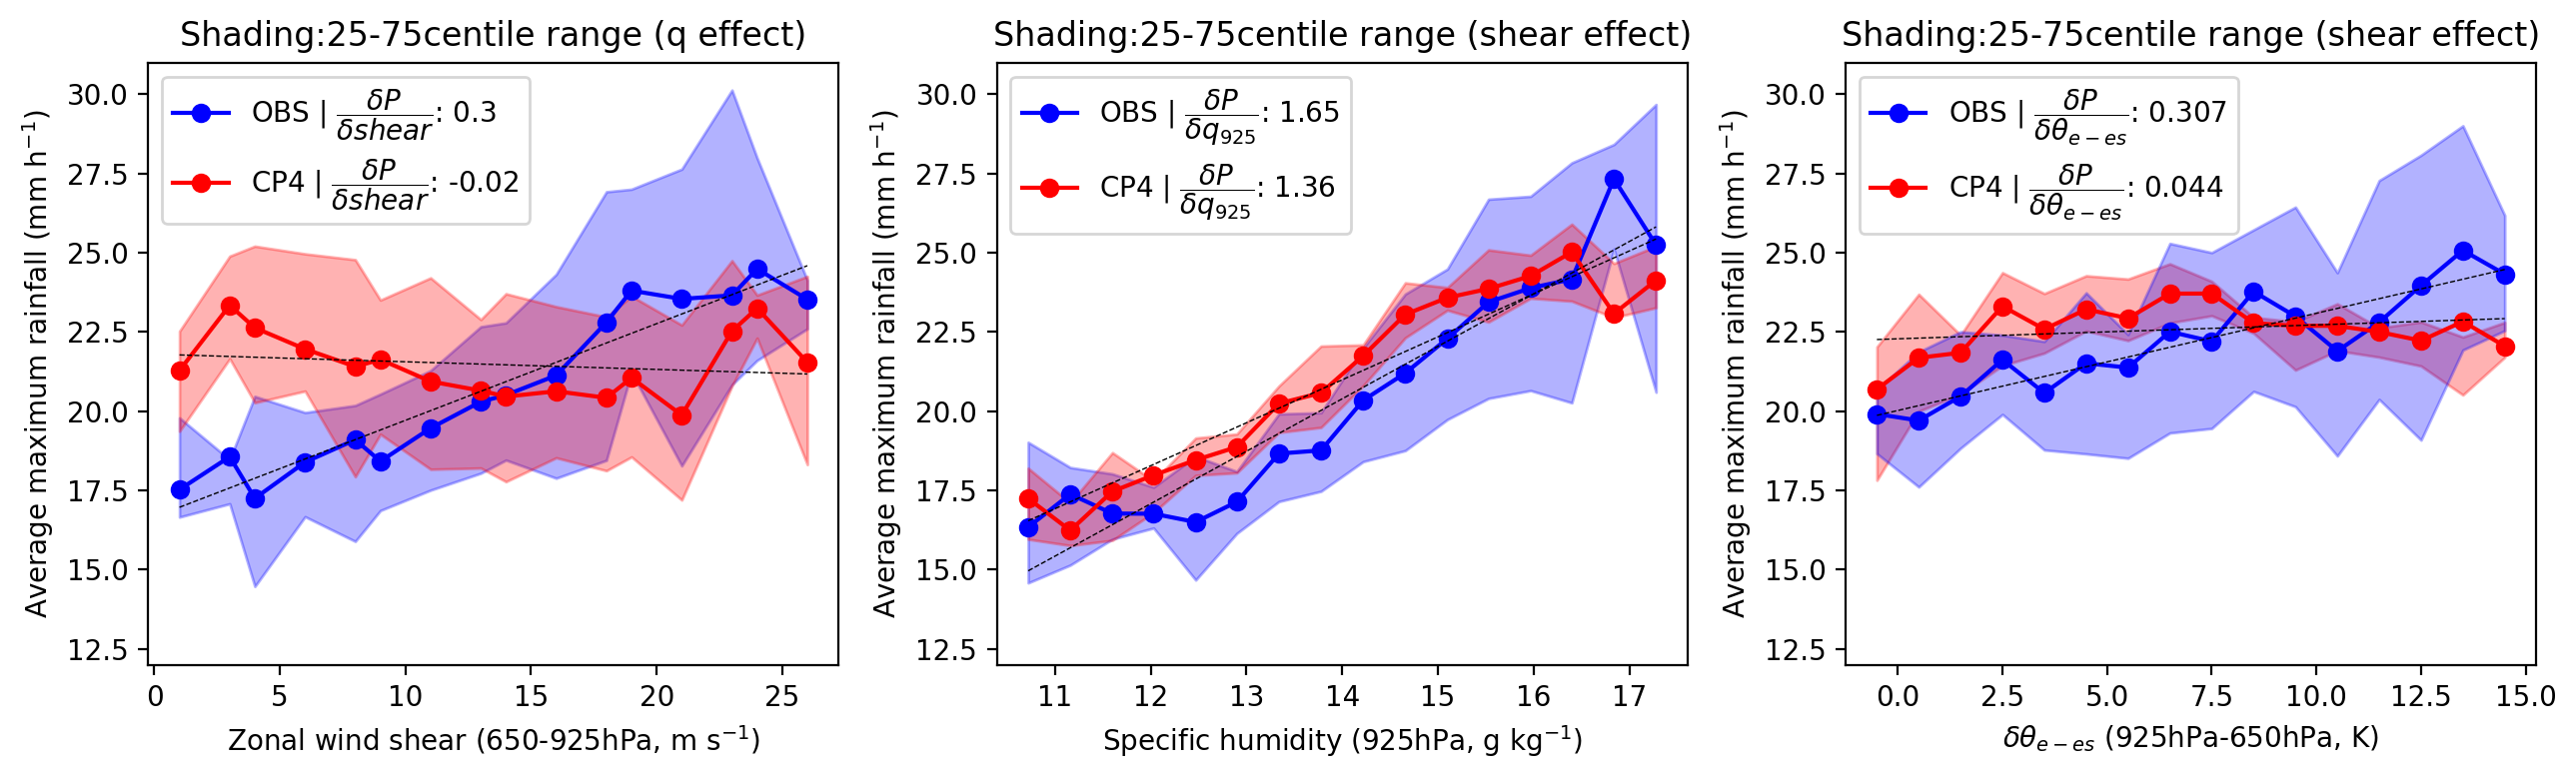

In [138]:
f = plt.figure(figsize=(13,4), dpi=200)
ax = f.add_subplot(131)

plt.plot(scollbins,pmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(PSslope,2)))
plt.fill_between(scollbins,p10,p90, color='blue', alpha=0.3)
plt.fill_between(scollbins,p104,p904, color='red', alpha=0.3)
plt.plot(scollbins,pmean4[0:-1], '-ro', label='CP4 | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(PSslope4,2)))
plt.plot(scollbins,PSslope*scollbins+PSintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(scollbins,PSslope4*scollbins+PSintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (q effect)')
plt.ylim(12,31)
#plt.ylim(15,33)
plt.legend(loc='upper left')

ax = f.add_subplot(132)
plt.plot(qcollbins,pqmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(PQslope,2)))
plt.fill_between(qcollbins,pq10,pq90, color='blue', alpha=0.3)
plt.fill_between(qcollbins,pq104,pq904, color='red', alpha=0.3)
plt.plot(qcollbins,pqmean4[0:-1], '-ro', label=r'CP4 | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(PQslope4,2)))
plt.plot(qcollbins,PQslope*qcollbins+PQintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(qcollbins,PQslope4*qcollbins+PQintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Specific humidity (925hPa, g kg$^{-1}$)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')

plt.ylim(12,31)
#plt.ylim(15,33)
plt.legend(loc='upper left')

ax = f.add_subplot(133)
plt.plot(thcollbins,meantheta[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(PTslope,3)))
plt.fill_between(thcollbins,theta104,theta904, color='red', alpha=0.3)
plt.fill_between(thcollbins,theta10,theta90, color='blue', alpha=0.3)
plt.plot(thcollbins,meantheta4[0:-1], '-ro', label=r'CP4 | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(PTslope4,3)))
plt.plot(thcollbins,PTslope*thcollbins+PTintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(thcollbins,PTslope4*thcollbins+PTintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel(r'$\delta \theta _{e-es}$ (925hPa-650hPa, K)')
plt.ylabel('Average maximum rainfall (mm h$^{-1}$)')
plt.title('Shading:25-75centile range (shear effect)')
plt.ylim(12,31)
#plt.ylim(1,33)
plt.legend(loc='upper left')

plt.tight_layout()
#f.savefig(cnst.network_data +'figs/CLOVER/OBS_CP4_lineplot_'+tag+'_15km_rain.png')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0, 4, 'h')

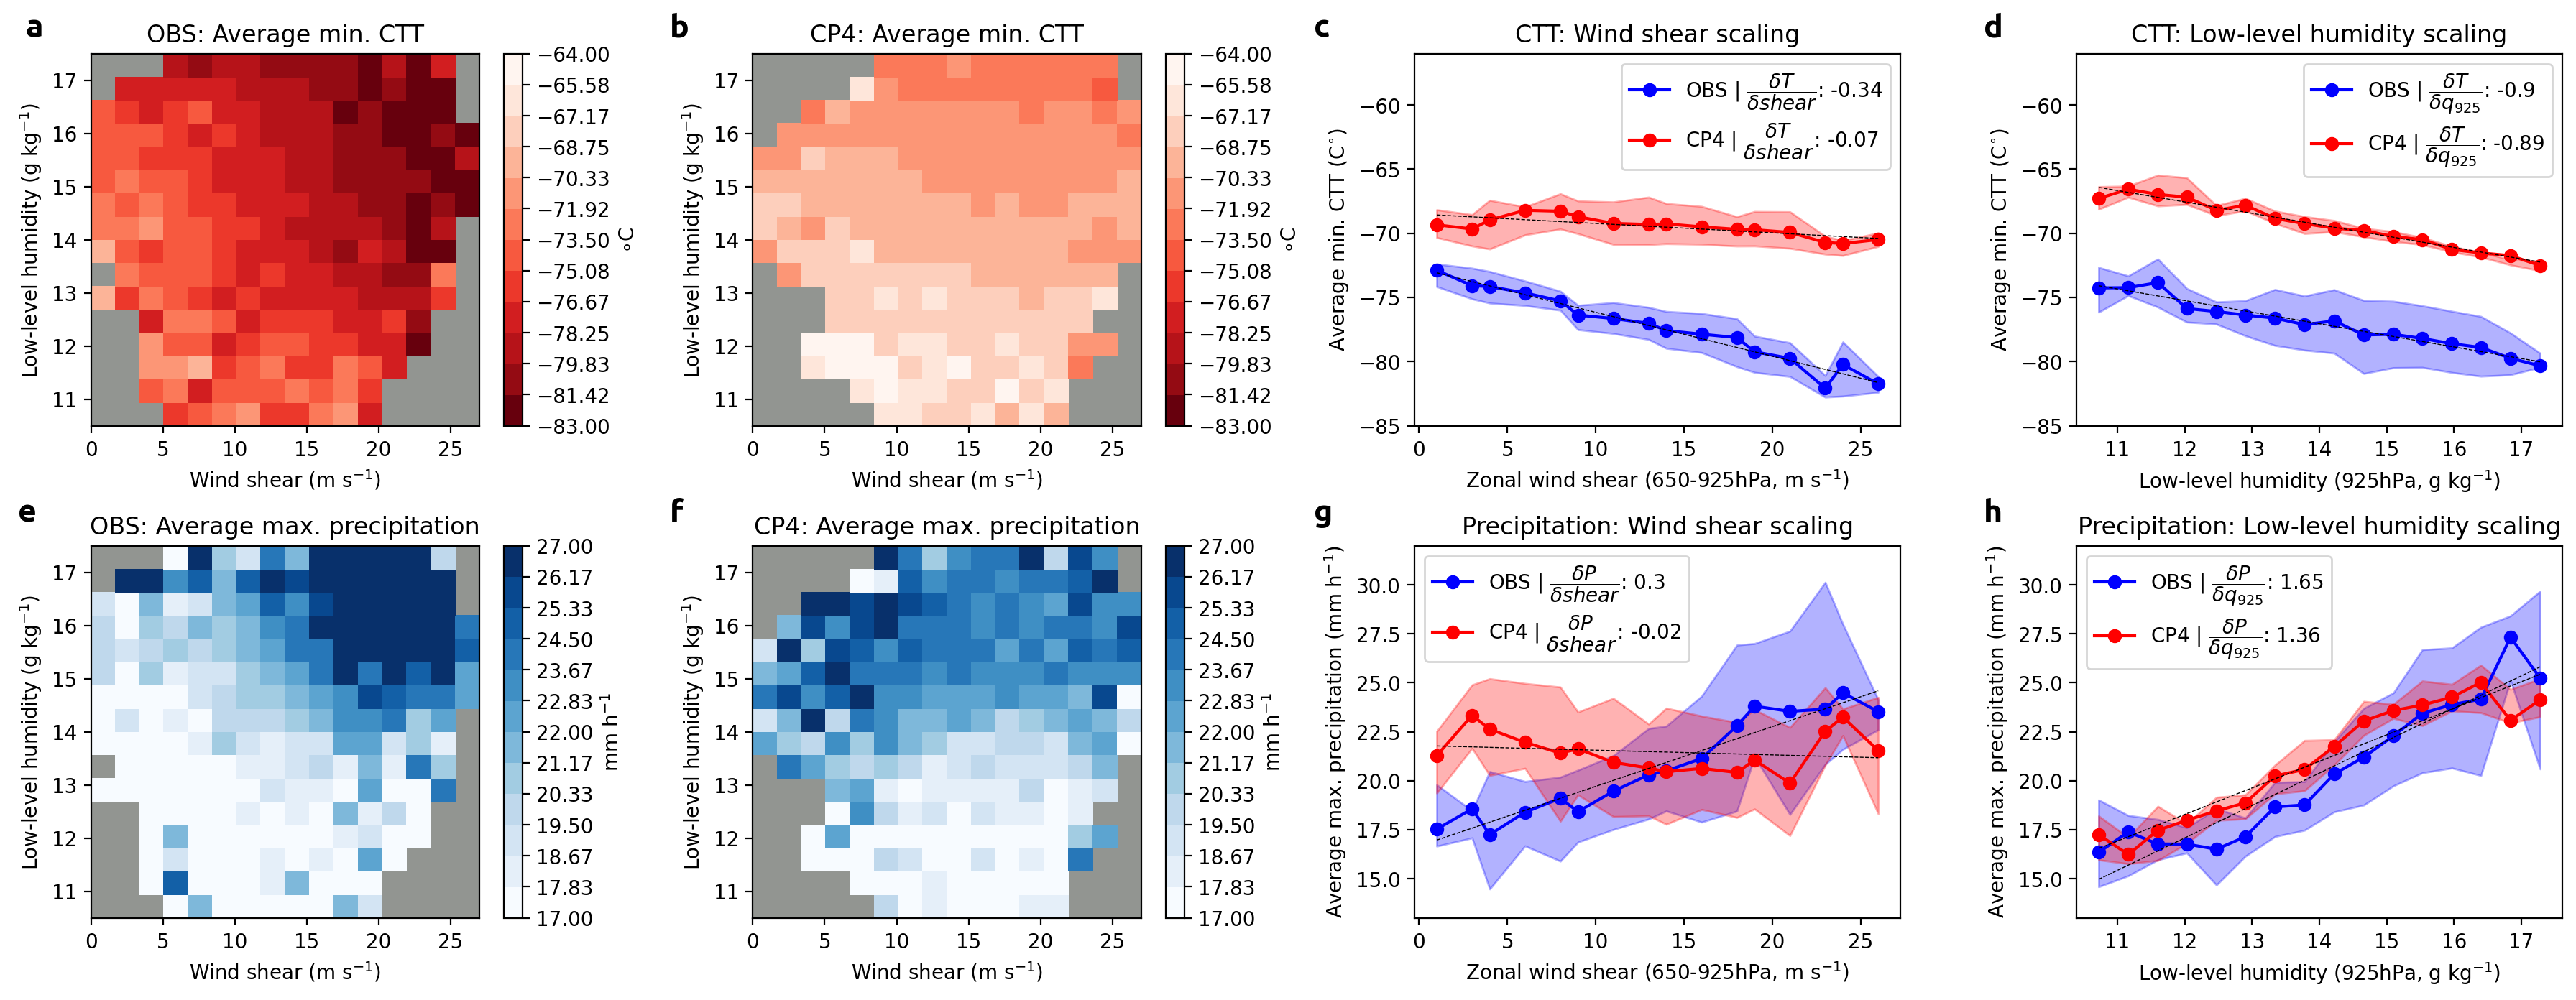

In [139]:
data = [tmin_dic_obs, tmin_dic_cp4,  prcp_dic_obs,prcp_dic_cp4]
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
f = plt.figure(figsize=(18,7), dpi=200)

for i, dat in enumerate(data):

    
    if i in [0,1]:
        ax = f.add_subplot(2,4,i+1)
        cmap = 'Reds_r'

        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(12, base_cmap=cmap)
    #         if valid:

    #             dat['data'][dat['valid']<5] = np.nan
        Zm = dat['data'].copy()
        npos = np.isnan(Zm)
    #         if i in [0,3]:
    #             Zm[np.isnan(Zm)] = np.nanmean(Zm)
    #         else:
    #             Zm[np.isnan(Zm)] = np.nanmax(Zm)
    #         Zm = ndimage.gaussian_filter(Zm, 0.6, mode='nearest')
        #Zm = ma.masked_where(np.isnan(Zm),Zm)
        Zm = ma.masked_where(npos,Zm)

        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],13)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    if i in [2,3]:
        ax = f.add_subplot(2,4,i+3)
        cmap = 'Blues'

        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(12, base_cmap=cmap)
    #         if valid:

    #             dat['data'][dat['valid']<5] = np.nan
        Zm = dat['data'].copy()
        npos = np.isnan(Zm)
    #         if i in [0,3]:
    #             Zm[np.isnan(Zm)] = np.nanmean(Zm)
    #         else:
    #             Zm[np.isnan(Zm)] = np.nanmax(Zm)
    #         Zm = ndimage.gaussian_filter(Zm, 0.6, mode='nearest')
        #Zm = ma.masked_where(np.isnan(Zm),Zm)
        Zm = ma.masked_where(npos,Zm)

        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],13)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])
        
ax = f.add_subplot(243)

plt.plot(scollbins,tmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta T}{\delta shear}$: ' + str(np.round(TSslope,2)))
plt.fill_between(scollbins,t10,t90, color='blue', alpha=0.3)
plt.fill_between(scollbins,t104,t904, color='red', alpha=0.3)
plt.plot(scollbins,tmean4[0:-1], '-ro', label='CP4 | $\dfrac{\delta T}{\delta shear}$: ' + str(np.round(TSslope4,2)))
plt.plot(scollbins,TSslope*scollbins+TSintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(scollbins,TSslope4*scollbins+TSintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel(r'Average min. CTT (C$^{\circ}$)')
plt.title('CTT: Wind shear scaling')
plt.ylim(-85,-56)
plt.legend(loc='upper right')

ax = f.add_subplot(244)
plt.plot(qcollbins,tqmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta T}{\delta q_{925}}$: ' + str(np.round(TQslope,2)))
plt.fill_between(qcollbins,tq10,tq90, color='blue', alpha=0.3)
plt.fill_between(qcollbins,tq104,tq904, color='red', alpha=0.3)
plt.plot(qcollbins,tqmean4[0:-1], '-ro', label=r'CP4 | $\dfrac{\delta T}{\delta q_{925}}$: ' + str(np.round(TQslope4,2)))
plt.plot(qcollbins,TQslope*qcollbins+TQintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(qcollbins,TQslope4*qcollbins+TQintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Low-level humidity (925hPa, g kg$^{-1}$)')
plt.ylabel(r'Average min. CTT (C$^{\circ}$)')
plt.title('CTT: Low-level humidity scaling')
plt.ylim(-85,-56)
plt.legend(loc='upper right')

ax = f.add_subplot(247)

plt.plot(scollbins,pmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(PSslope,2)))
plt.fill_between(scollbins,p10,p90, color='blue', alpha=0.3)
plt.fill_between(scollbins,p104,p904, color='red', alpha=0.3)
plt.plot(scollbins,pmean4[0:-1], '-ro', label='CP4 | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(PSslope4,2)))
plt.plot(scollbins,PSslope*scollbins+PSintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(scollbins,PSslope4*scollbins+PSintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('Average max. precipitation (mm h$^{-1}$)')
plt.title('Precipitation: Wind shear scaling')
plt.ylim(13,32)
#plt.ylim(15,33)
plt.legend(loc='upper left')

ax = f.add_subplot(248)
plt.plot(qcollbins,pqmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(PQslope,2)))
plt.fill_between(qcollbins,pq10,pq90, color='blue', alpha=0.3)
plt.fill_between(qcollbins,pq104,pq904, color='red', alpha=0.3)
plt.plot(qcollbins,pqmean4[0:-1], '-ro', label=r'CP4 | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(PQslope4,2)))
plt.plot(qcollbins,PQslope*qcollbins+PQintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(qcollbins,PQslope4*qcollbins+PQintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Low-level humidity (925hPa, g kg$^{-1}$)')
plt.ylabel('Average max. precipitation (mm h$^{-1}$)')
plt.title('Precipitation: Low-level humidity scaling')

plt.ylim(13,32)
#plt.ylim(15,33)
plt.legend(loc='upper left')


plt.tight_layout() 

text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
y1 = 0.955
y2 = 0.47
plt.annotate(text[0], xy=(0.01, y1), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.26, y1), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.51, y1), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.77, y1), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.007, y2), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[5], xy=(0.26, y2), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[6], xy=(0.51, y2), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[7], xy=(0.77, y2), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
#plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_8x_'+tag+'_15km.png')

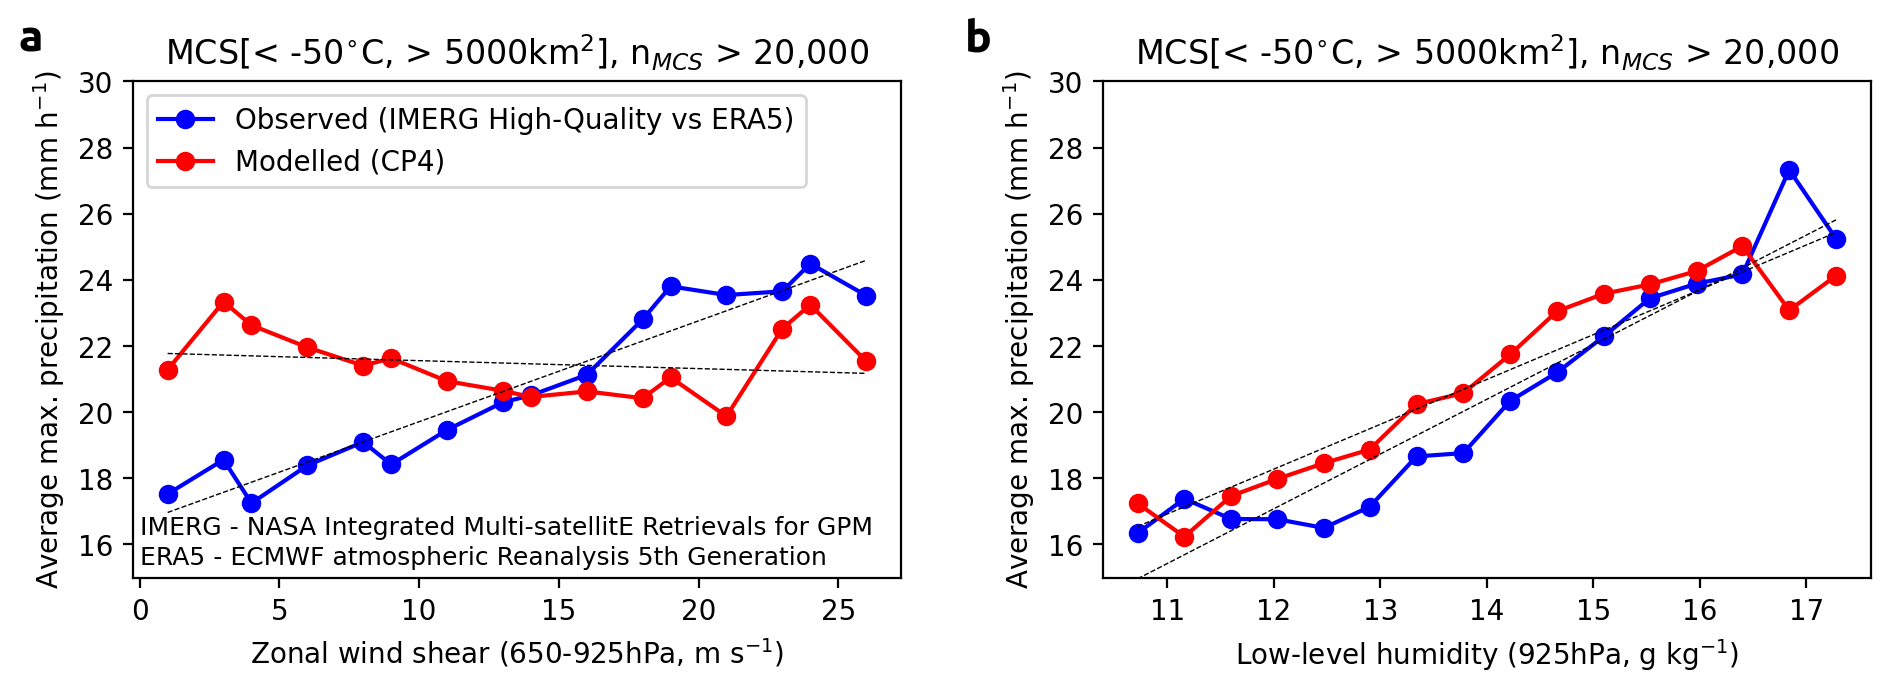

In [140]:
data = [prcp_dic_obs,prcp_dic_cp4]
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
f = plt.figure(figsize=(9.5,3.5), dpi=200)

ax = f.add_subplot(121)

plt.plot(scollbins,pmean[0:-1], '-bo', label=r'Observed (IMERG High-Quality vs ERA5)')
#plt.fill_between(scollbins,p10,p90, color='blue', alpha=0.3)
#plt.fill_between(scollbins,p104,p904, color='red', alpha=0.3)
plt.plot(scollbins,pmean4[0:-1], '-ro', label='Modelled (CP4)')
plt.plot(scollbins,PSslope*scollbins+PSintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(scollbins,PSslope4*scollbins+PSintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Zonal wind shear (650-925hPa, m s$^{-1}$)')
plt.ylabel('Average max. precipitation (mm h$^{-1}$)')
plt.title('MCS[< -50$^{\circ}$C, > 5000km$^{2}$], n$_{MCS}$ > 20,000')
plt.ylim(15,30)
plt.text(0,16.3, 'IMERG - NASA Integrated Multi-satellitE Retrievals for GPM', fontsize=9)
plt.text(0,15.4, 'ERA5 - ECMWF atmospheric Reanalysis 5th Generation', fontsize=9)
#plt.ylim(15,33)
plt.legend(loc='upper left')

ax = f.add_subplot(122)
plt.plot(qcollbins,pqmean[0:-1], '-bo', label=r'Observed (Global Precipitation Measurement Mission High-Quality)')
#plt.fill_between(qcollbins,pq10,pq90, color='blue', alpha=0.3)
#plt.fill_between(qcollbins,pq104,pq904, color='red', alpha=0.3)
plt.plot(qcollbins,pqmean4[0:-1], '-ro', label=r'Modelled (CP4)')
plt.plot(qcollbins,PQslope*qcollbins+PQintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(qcollbins,PQslope4*qcollbins+PQintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Low-level humidity (925hPa, g kg$^{-1}$)')
plt.ylabel('Average max. precipitation (mm h$^{-1}$)')
#plt.title('Maximum MCS rainfall vs. PBL moisture')
plt.title('MCS[< -50$^{\circ}$C, > 5000km$^{2}$], n$_{MCS}$ > 20,000')


plt.ylim(15,30)
#plt.ylim(15,33)
#plt.legend(loc='upper left')


plt.tight_layout() 

text = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
y1 = 0.91
y2 = 0.47
plt.annotate(text[0], xy=(0.01, y1), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.51, y1), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.51, y1), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[3], xy=(0.77, y1), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[4], xy=(0.007, y2), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[5], xy=(0.26, y2), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[6], xy=(0.51, y2), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[7], xy=(0.77, y2), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_2x_MCSproposal_'+tag+'_15km.jpg')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


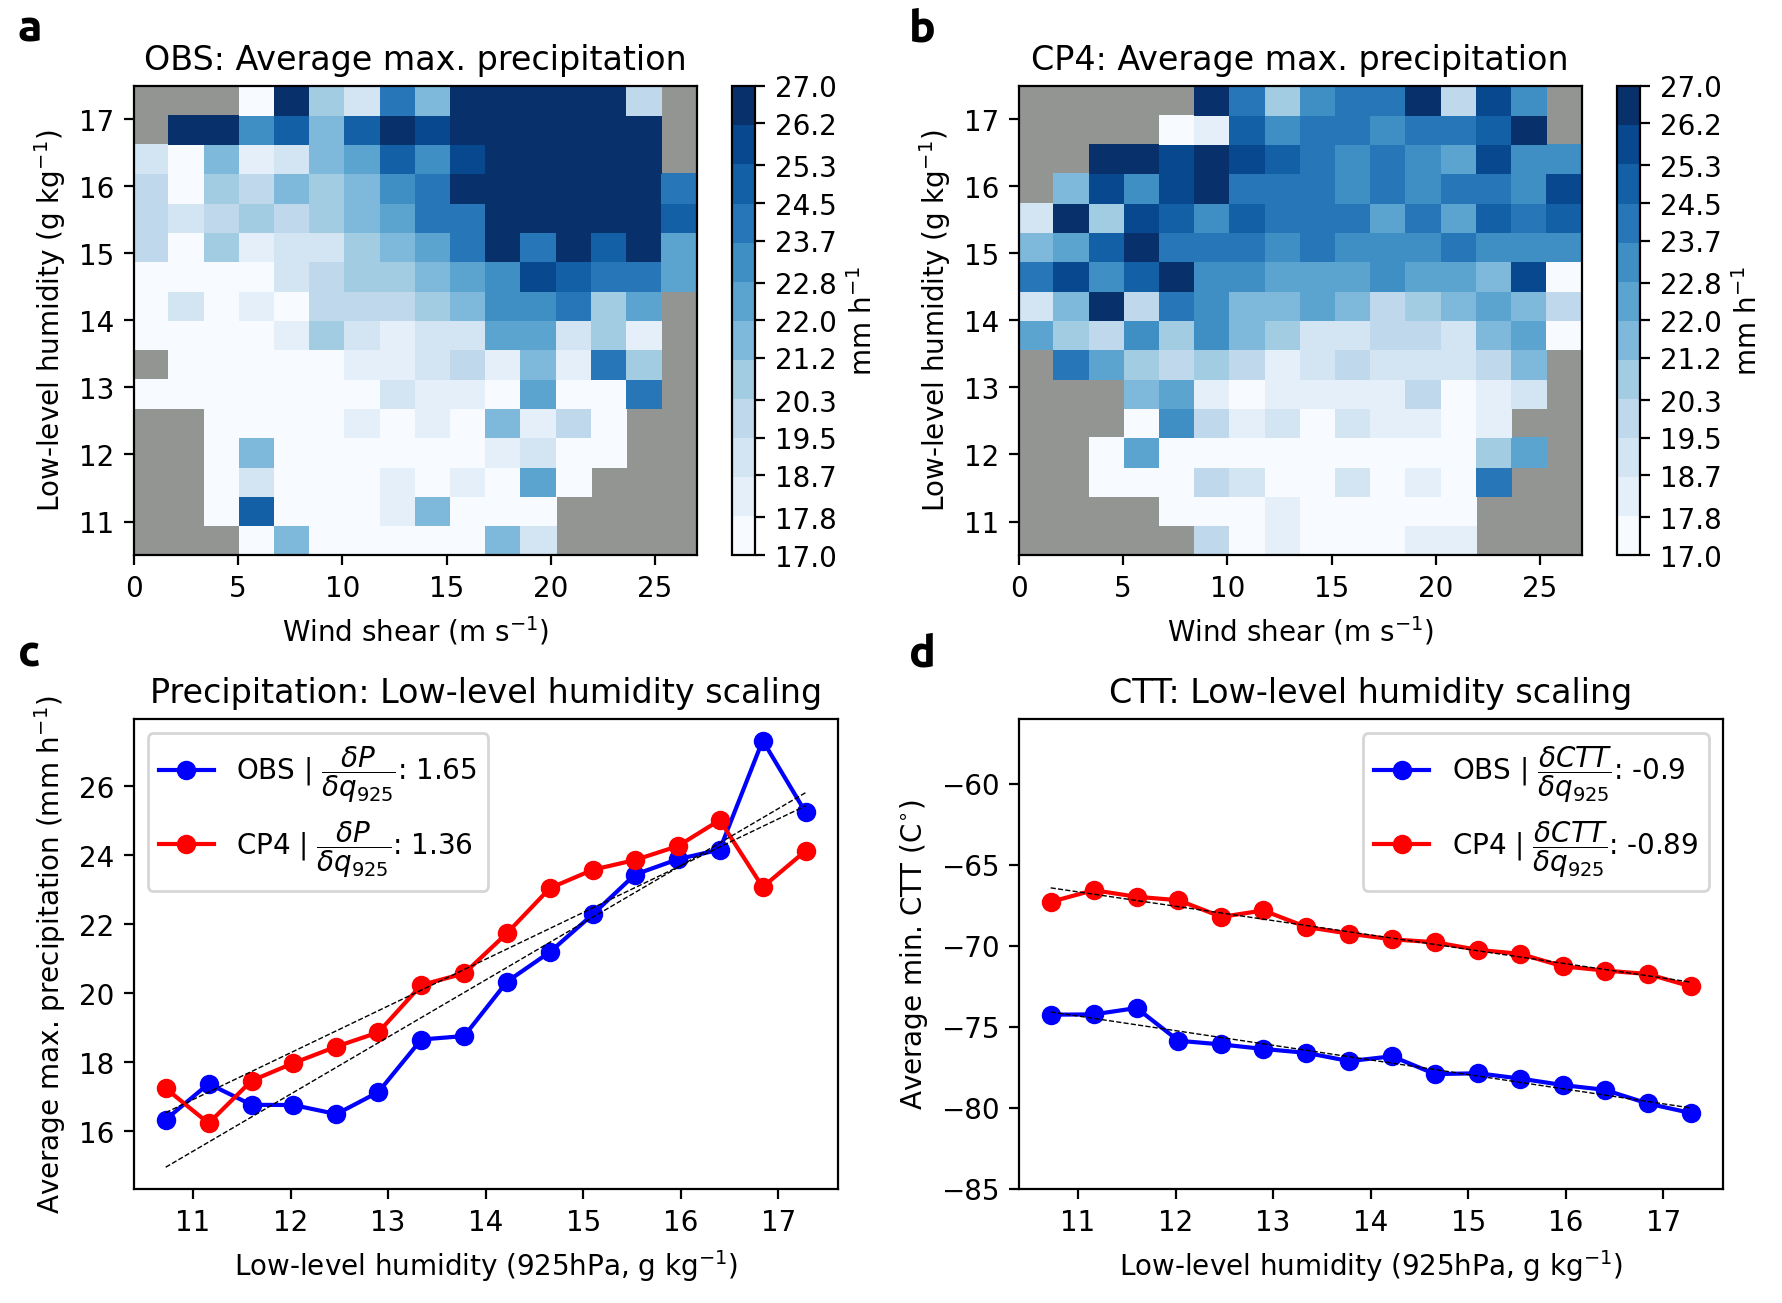

In [152]:
data = [prcp_dic_obs,prcp_dic_cp4]
    
    #from palettable.colorbrewer.qualitative import Blues_6, Reds_6_r
    
f = plt.figure(figsize=(9,6.5), dpi=200)

for i, dat in enumerate(data):

    if i in [0,1]:
        ax = f.add_subplot(2,2,i+1)
        cmap = 'Blues'

        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(12, base_cmap=cmap)
    #         if valid:

    #             dat['data'][dat['valid']<5] = np.nan
        Zm = dat['data'].copy()
        npos = np.isnan(Zm)
    #         if i in [0,3]:
    #             Zm[np.isnan(Zm)] = np.nanmean(Zm)
    #         else:
    #             Zm[np.isnan(Zm)] = np.nanmax(Zm)
    #         Zm = ndimage.gaussian_filter(Zm, 0.6, mode='nearest')
        #Zm = ma.masked_where(np.isnan(Zm),Zm)
        Zm = ma.masked_where(npos,Zm)

        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_facecolor('xkcd:grey')
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.round(np.linspace(dat['vmin'],dat['vmax'],13),1)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

ax = f.add_subplot(223)
plt.plot(qcollbins,pqmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(PQslope,2)))
# plt.fill_between(qcollbins,pq10,pq90, color='blue', alpha=0.3)
# plt.fill_between(qcollbins,pq104,pq904, color='red', alpha=0.3)
plt.plot(qcollbins,pqmean4[0:-1], '-ro', label=r'CP4 | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(PQslope4,2)))
plt.plot(qcollbins,PQslope*qcollbins+PQintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(qcollbins,PQslope4*qcollbins+PQintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Low-level humidity (925hPa, g kg$^{-1}$)')
plt.ylabel('Average max. precipitation (mm h$^{-1}$)')
plt.title('Precipitation: Low-level humidity scaling')
plt.legend(loc='upper left')

ax = f.add_subplot(224)
plt.plot(qcollbins,tqmean[0:-1], '-bo', label=r'OBS | $\dfrac{\delta CTT}{\delta q_{925}}$: ' + str(np.round(TQslope,2)))
# plt.fill_between(qcollbins,tq10,tq90, color='blue', alpha=0.3)
# plt.fill_between(qcollbins,tq104,tq904, color='red', alpha=0.3)
plt.plot(qcollbins,tqmean4[0:-1], '-ro', label=r'CP4 | $\dfrac{\delta CTT}{\delta q_{925}}$: ' + str(np.round(TQslope4,2)))
plt.plot(qcollbins,TQslope*qcollbins+TQintercept, linestyle='dashed', color='k', linewidth=0.5)
plt.plot(qcollbins,TQslope4*qcollbins+TQintercept4, linestyle='dashed', color='k', linewidth=0.5)
plt.xlabel('Low-level humidity (925hPa, g kg$^{-1}$)')
plt.ylabel(r'Average min. CTT (C$^{\circ}$)')
plt.title('CTT: Low-level humidity scaling')
plt.ylim(-85,-56)
plt.legend(loc='upper right')



plt.tight_layout() 

text = ['a', 'b', 'c', 'd']#, 'e', 'f', 'g', 'h']
y1 = 0.96
y2 = 0.48
plt.annotate(text[0], xy=(0.01, y1), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.51, y1), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.01, y2), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.51, y2), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[4], xy=(0.007, y2), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[5], xy=(0.26, y2), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[6], xy=(0.51, y2), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[7], xy=(0.77, y2), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.savefig(cnst.network_data + 'figs/ENDGAME/OBS_CP4_2dHist_4x_MCSproposal_'+tag+'_15km_bams.jpg')